In [9]:
#import dependencies
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np
#load cpu context, if using cpu mx.gpu(0)
context= mx.gpu(0)

In [10]:
# brine for loading anime-faces dataset
import brine
anime_train = brine.load_dataset('jayleicn/anime-faces')

In [11]:
type(anime_train.columns)

brine.dataset.Column

In [12]:
len(anime_train)

115085

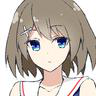

In [13]:
anime_train.load_image(anime_train[0].image)

In [14]:
#training only with 35085 images due to time constraints
_, training_folder = anime_train.create_folds([80000],shuffle=True)
print(len(training_folder))

35085


In [15]:
target_wd = 64
target_ht = 64
img_list = []

# tranform image. Image are normally (width X height X channels)
# mxnet uses (channels X width X height)
def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3) 
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    return data.reshape((1,) + data.shape)

# Read images, call the transform function, attach it to list
def getImageList(base_path,training_folder):
    img_list = []
    for train in training_folder:
        fname = base_path + train.image
        img_arr = mx.image.imread(fname)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
    return img_list

base_path = 'brine_datasets/jayleicn/anime-faces/images/'
img_list = getImageList('brine_datasets/jayleicn/anime-faces/images/',training_folder)


In [16]:
batch_size = 64
latent_z_size = 150
# creates as 
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

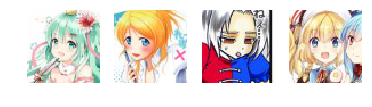

In [17]:
#visualisation, we need transponse since imshow expects width X height X channels
# whereas mxnet uses channels widht X height
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

In [18]:
#example of upsampling

#produce random vector of shape (1 X 150 X 1 X 1). Order is (Batchsize, channels, X dimenions, Y dimension)
random_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=context)
netTest = nn.Sequential()

with netTest.name_scope():
    # input is Z, going into a convolution. (100X1X1). Ignored the batch size
    # The upsamples is applied only for X and Y dimensions
    netTest.add(nn.Conv2DTranspose(48, 4, 1, 0, use_bias=False)) # 48 filters, upsamples by 4, with 1 stride, 0 padding
    # The output from previous convolution is of dimension (48 X 4 X 4) . Ignored the batch size
    netTest.add(nn.Conv2DTranspose(48, 4, 2, 1, use_bias=False)) # 48 filters, upsamples by 4, with 2 stride, 1 padding
    netTest.add(nn.Conv2DTranspose(48, 4, 2, 1, use_bias=False))
   
netTest.initialize(mx.init.Normal(0.02), ctx=context)
abc = netTest(random_z)
print("The input shape is", random_z.shape)
print("The ouput shape is", abc.shape)

The input shape is (1, 150, 1, 1)
The ouput shape is (1, 48, 16, 16)


In [19]:
epochs = 10 # Set low by default for tests, set higher when you actually run this code.
batch_size = 64
random_z = 150 # The latent input size of the generators
lr = 0.0002
beta1 = 0.5

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()


In [20]:
# build the generator
nc = 3 # number of channel
ngf = 64 # final image width X height
netG = nn.Sequential()  # sequential model 

# simple generator. Use any models but should upscale the latent variable(randome vectors) to 64 * 64 * 3 channel image
with netG.name_scope():
     # input is random_z (batchsize X 150 X 1), going into a tranposed convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # output size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # output size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # output size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # output size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1))
    netG.add(nn.Activation('tanh')) # use tanh , we need an output that is between -1 to 1, not 0 to 1 
    # Rememeber the input image is normalised between -1 to 1, so should be the output
    # output size. (nc) x 64 x 64

# build the discriminator model
ndf = 64
netD = nn.Sequential()
# maps 
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1))
    netD.add(nn.LeakyReLU(0.2))
    # output size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # output size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # output size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # output size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0))

In [21]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
# reset the iterator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)
train_data.reset()

for batch in train_data:
    sample = batch.data[0].as_in_context(ctx)
    #print(sample.shape)
    break
print(sample.shape)

out = netD(sample)
sample_label = nd.zeros((batch_size,), ctx=ctx)
print(loss(out,sample_label).shape)

(64, 3, 64, 64)
(64,)


In [22]:
# loss


# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [23]:
from datetime import datetime
import time
import logging

train_data.reset()

#initialise some labels of calculating the loss
#real label is the labels of real image
real_label = nd.ones((batch_size,), ctx=ctx)

#fake labels is label associated with fake image
fake_label = nd.zeros((batch_size,),ctx=ctx)


logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        random_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            
             ############################
             # (2) Update Discrimator update step
             ###########################
            
            # train with real image
            output = netD(data).reshape((-1, 1))
            #The loss is a real valued number
            errD_real = loss(output, real_label)
            
            #train with fake image, see the what the discriminator predicts
            #creates fake imge
            fake = netG(random_z)
            
            # pass it to discriminator
            output = netD(fake.detach()).reshape((-1, 1))
            
            errD_fake = loss(output, fake_label)
            
            #compute the total error for fake image and the real image
            errD = errD_real + errD_fake
            
            #improve the discriminator skill by back propagating the error
            errD.backward()

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update Generator update step
        ###########################
        with autograd.record():
            fake = netG(random_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 1024 == 0:
            logging.info('discriminator loss = %f, generator loss = %f, at iter %d epoch %d' 
                     %(nd.mean(errD).asscalar(), 
                       nd.mean(errG).asscalar(), iter, epoch))
        iter = iter + 1
     


INFO:root:discriminator loss = 2.019658, generator loss = 4.711029, at iter 0 epoch 0
INFO:root:discriminator loss = 0.306075, generator loss = 5.829125, at iter 0 epoch 1
INFO:root:discriminator loss = 0.536451, generator loss = 6.646788, at iter 0 epoch 2
INFO:root:discriminator loss = 0.266427, generator loss = 4.546894, at iter 0 epoch 3
INFO:root:discriminator loss = 0.215047, generator loss = 5.079801, at iter 0 epoch 4
INFO:root:discriminator loss = 0.284719, generator loss = 6.345932, at iter 0 epoch 5
INFO:root:discriminator loss = 0.500637, generator loss = 3.216483, at iter 0 epoch 6
INFO:root:discriminator loss = 0.145513, generator loss = 3.524334, at iter 0 epoch 7
INFO:root:discriminator loss = 0.225620, generator loss = 5.069639, at iter 0 epoch 8
INFO:root:discriminator loss = 0.209951, generator loss = 4.721691, at iter 0 epoch 9


In [24]:
os.makedirs('checkpoints_GAN', exist_ok=True)
save_GAN = "checkpoints_GAN/GAN_t2.params" 
netG.save_params(save_GAN)

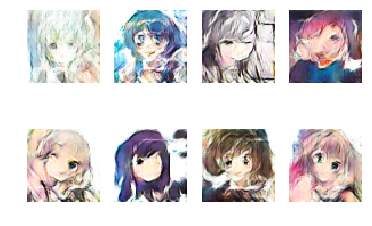

In [25]:
# Lets generate some random images
# Download the trained model parameters from https://www.dropbox.com/s/uu45cq5y6uigiro/GAN_t2.params?dl=0
# netG.load_params(save_GAN,context)
num_image = 8
for i in range(num_image):
    # randome input for the generating images
    random_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(random_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()